In [6]:
library(repr)
options(repr.plot.width=7, repr.plot.height=4.5)

# eventEst.R

Some visual investigations into the distributions of sampled event latencies against estimated occurrences (using Uri Shaft technique) What does the sampled event stream tell about how feequently things are actually happening i the database, given sampler bias to longer latencies?

## Environment
Do the usual package loads and ashDF data frame creation.

In [7]:
#install.packages("~/Desktop/Professional/Dev/ASHviz/ashdat_0.1.0.tar.gz", repos = NULL)
install.packages("./ashdat_0.1.0.tar.gz", repos = NULL)

library(ashdat)
library(dplyr)
library(ggplot2)

ashDF <- ashdat::ASHDUMP1


Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



## Events data frame
This notebook focuses on event latencies so the data frame Events is ashDF filtered for waits only. Filtering for `TIME_WAITED > 0` selects samples with values updated by the **ASH fix-up mechanism**. It's also worth noting that only the final sample row will be selected for very long events that may have been sampled multiple times, as only this row has the `TIME_WAITED` fixed up.

In [8]:
Events <- ashDF %>% filter( TIME_WAITED > 0 )

## Sampled event latency distributions
We start by using box-whisket plots to get insight into the distributions of event latencies, broken out by wait class and event.

## Summary statistics: geom_boxplot ( )
Boxplots can be used to characterize and compare the sampled latency distributions.

Boxplot using aesthetic `y = log10(TIME_WAITED)` over all sampled events to get big picture of event latencies. Since `TIME_WAITED` is in microseconds, the values 3 and 6 correspond to 1 millisecond and 1 second respectively.

Note that the 50% box lies between 4 and 5.5 or so, meaning most sampled event latencies are between 10 and 300 or so milliseconds. Remember that the ASH sampler is biased to longer latencies; probability of being sampled is `( TIME_WAITED / 1000000 microsecs )` and therefore larger for longer events.

Also note a strong tail of observations below 100 microseconds that might be interesting to examine.

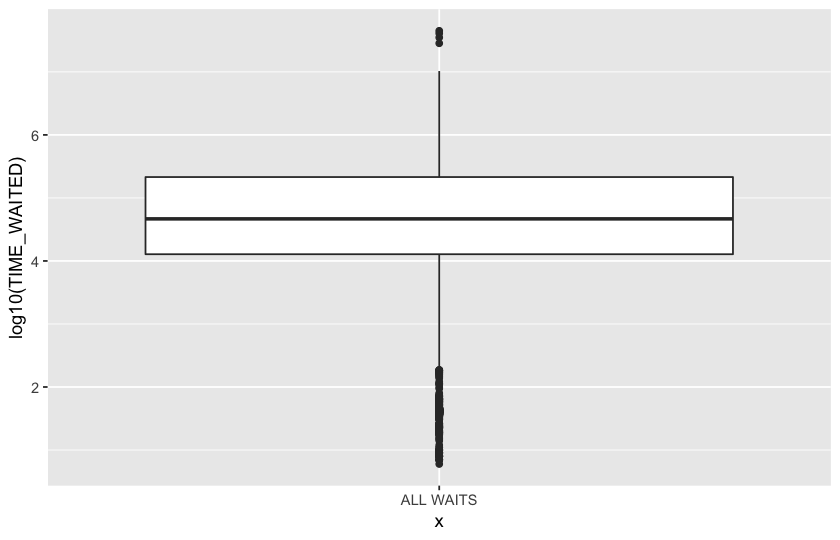

In [9]:
ggplot(data=Events, aes(x="ALL WAITS" ,y=log10(TIME_WAITED))) +
  geom_boxplot()

Adding the aesthetic `x = WAITCLASS` creates seperate box plots for each wait class, facilitating comparison across wait classes. Also, red intercepts are added at 1 sec and 1 millisecond for visual cross-reference.

We see that for all wait classes most sampled latencies are between 1 millisecond and 1 second. The *very* notable exception is the Idle class, notable both for minimal latency but also for being there at all given that Idle events are not supposed to be sampled into ASH (!?!)

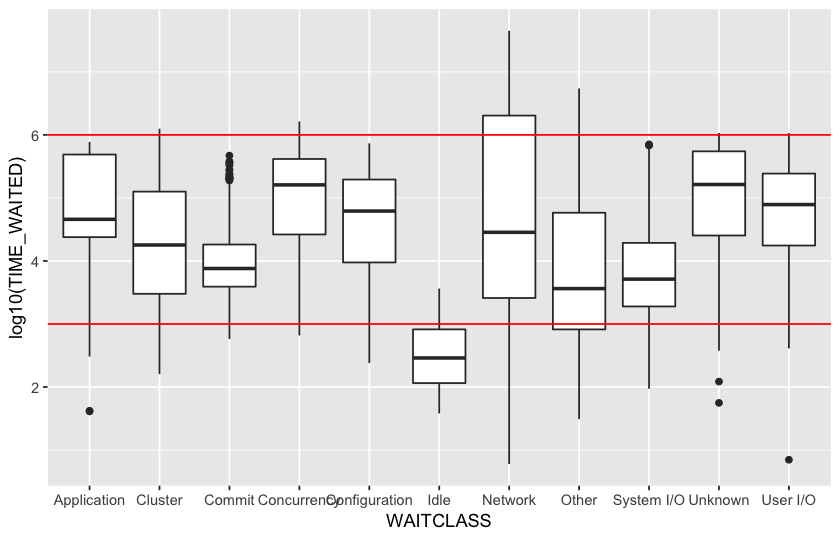

In [10]:
ggplot(data=Events, aes(x=WAITCLASS ,y=log10(TIME_WAITED))) +
  geom_boxplot() + 
  geom_hline(yintercept=c(3,6),color="red")

So what happens if we use aesthetic `x = EVENT_ID`?

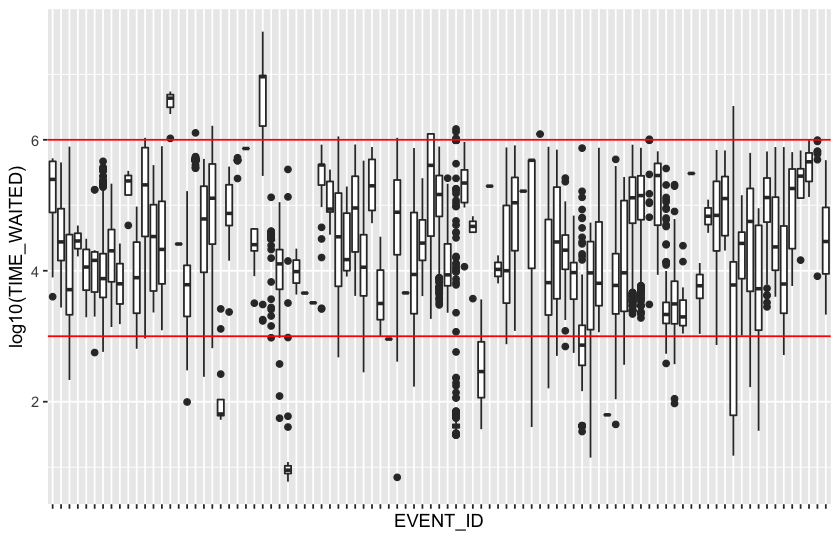

In [11]:
ggplot(data=Events, aes(x=EVENT_ID ,y=log10(TIME_WAITED))) +
  geom_boxplot() + 
  geom_hline(yintercept=c(3,6),color="red") + scale_x_discrete(labels=NULL)

How about adding to the mess with `color = WAITCLASS`? Ouch, that hurts.

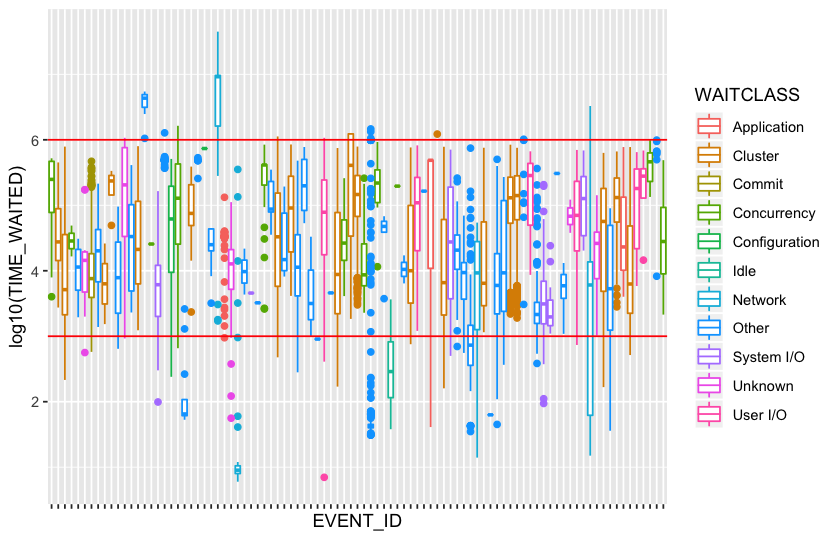

In [12]:
ggplot(data=Events %>% group_by(WAITCLASS), aes(x=EVENT_ID ,y=log10(TIME_WAITED))) +
  geom_boxplot(aes(color=WAITCLASS)) + 
  geom_hline(yintercept=c(3,6),color="red") + scale_x_discrete(labels=NULL)

Maybe if the event boxplots were arranged by event within wait class it would look better? In the code below the key is computing `NEW_ID` for the x-axis as the `paste` of wait class name and event name.

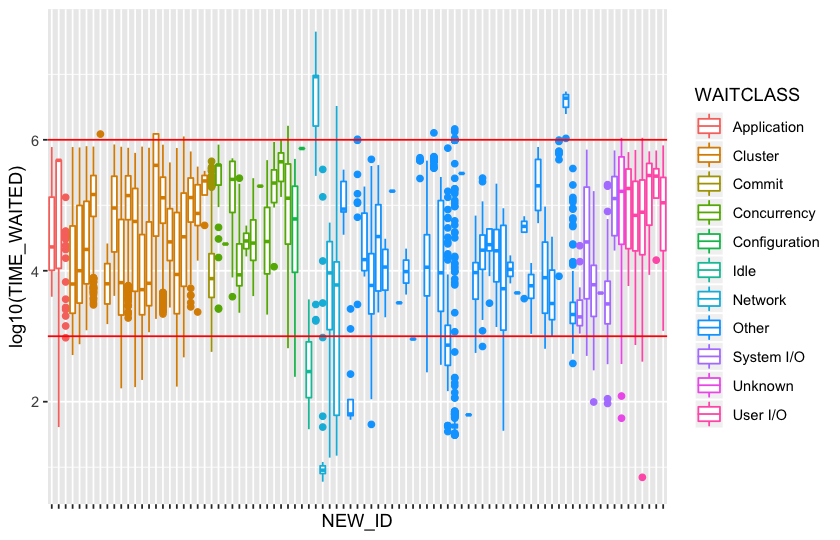

In [13]:
ggplot(data = Events %>% as_tibble() %>% mutate(NEW_ID = paste(WAITCLASS,EVENTNAME, sep = '.') )
      ,aes( x = NEW_ID , y = log10( TIME_WAITED ) ) ) +
  geom_boxplot(aes( color = WAITCLASS ) ) + 
  geom_hline( yintercept = c(3,6), color = "red")  + scale_x_discrete( labels = NULL)

Even though this is much improved, the horizontal space is very crowded from so many box plots, making them difficult to read. And of course we can't print out all the `NEW_ID` values. So this is still not that useful.

We can use faceting to separate out events by wait class into separate mini-plots. Unfortunately, the boxes are squeezed even tighter, as each mini-plot tries renders the total event (x) axis. Visualization fail.

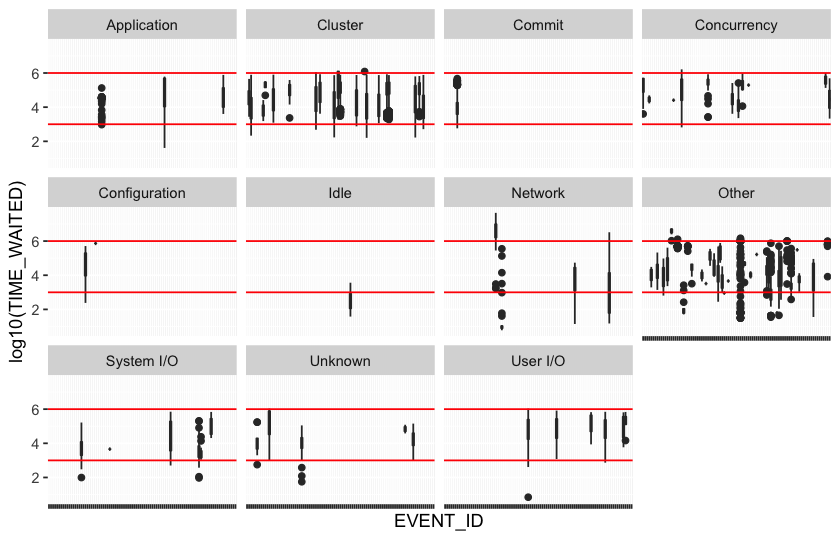

In [14]:
ggplot(data=Events %>% group_by(WAITCLASS), aes(x=EVENT_ID ,y=log10(TIME_WAITED))) +
  geom_boxplot() + facet_wrap(~WAITCLASS) +
  geom_hline(yintercept=c(3,6),color="red") + scale_x_discrete(labels=NULL)

When the x scale is freed in the faceted plots each wait class (facet) uses its full space to plot only events observed from that class. This allows the individual event boxplots to be as large as possible and still be grouped by wait class, and thus much more readable.

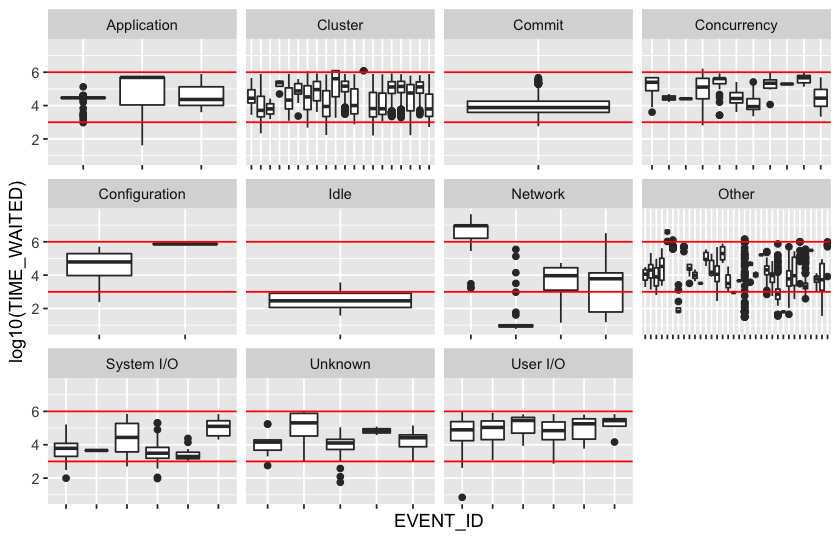

In [15]:
ggplot(data=Events %>% group_by(WAITCLASS), aes(x=EVENT_ID ,y=log10(TIME_WAITED))) +
  geom_boxplot() + facet_wrap(.~WAITCLASS, scales="free_x") +
  geom_hline(yintercept=c(3,6),color="red") + scale_x_discrete(labels=NULL)

What happens when we reverse the x and y variables in the aesthetic? My intuition would be horizontally oriented boxplots.

Did not turn out at all like expected, even worse than the skinny vertical ones above. 

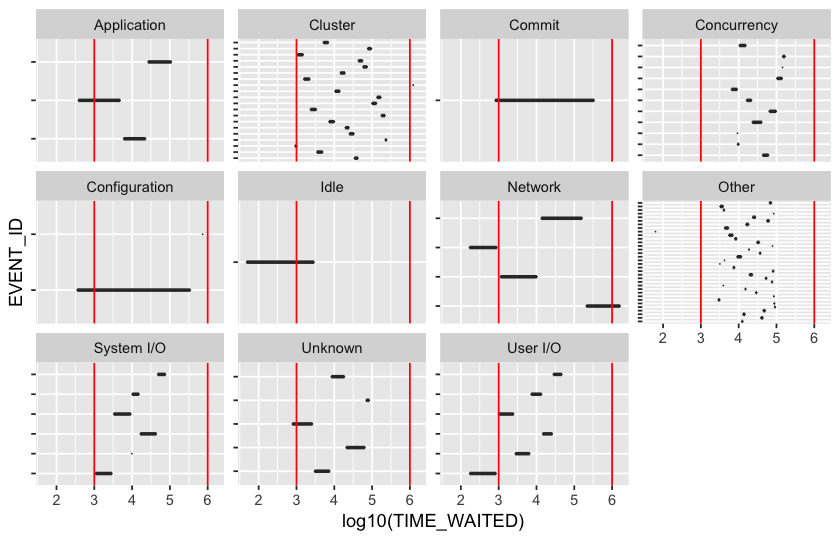

In [16]:
ggplot(data=Events %>% group_by(WAITCLASS), aes(y=EVENT_ID ,x=log10(TIME_WAITED))) +
  geom_boxplot() + facet_wrap(.~WAITCLASS, scales="free_y") +
  geom_vline(xintercept=c(3,6),color="red") + scale_y_discrete(labels=NULL)

It turns out that instead of reversing the aesthetic mappings for x and y, there is a much simpler way to turn a plot on its side using the `ggplot` function `coord_flip( )`. 

Appending a `ggplot2::coord_flip()` call to the earlier plot code does the job. No need to reverse x and y and change scaling calls. However, these plots seem much harder to read than vertical boxplots, so not really an improvement. 

(Good to know about `coord_flip()` though.)

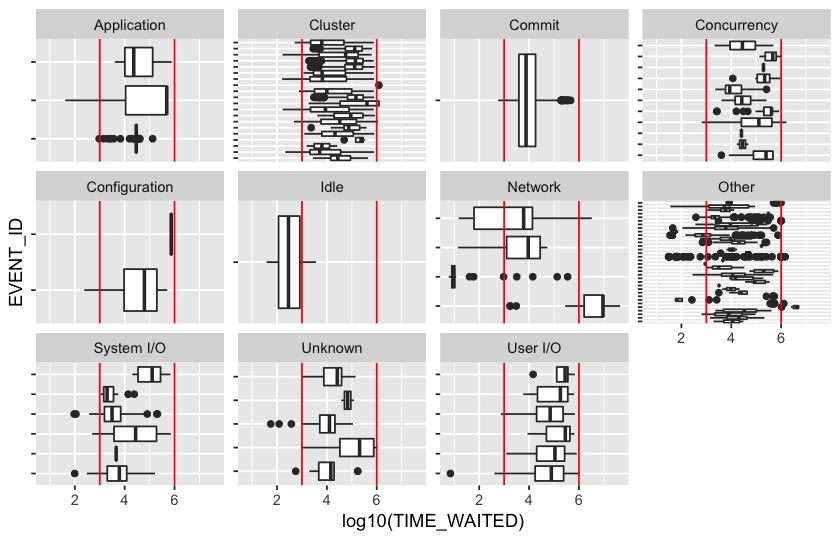

In [17]:
ggplot(data=Events %>% group_by(WAITCLASS), aes(x=EVENT_ID ,y=log10(TIME_WAITED))) +
  geom_boxplot() + facet_wrap(.~WAITCLASS, scales="free_y") +
  geom_hline(yintercept=c(3,6),color="red") + scale_x_discrete(labels=NULL) +
  ggplot2::coord_flip()

## Density plots: geom_density( )
Density plots show a smooth probability distribution curve fitted to the sample data. We are interested in the distribution of event wait time latencies and plot densities for `x = log10(TIME_WAITED)`

Note the use of `qplot` instead of `ggplot` for initial experiments, for brevity only. In `qplot` the geom is specified as a parameter: `geom = c("density")`

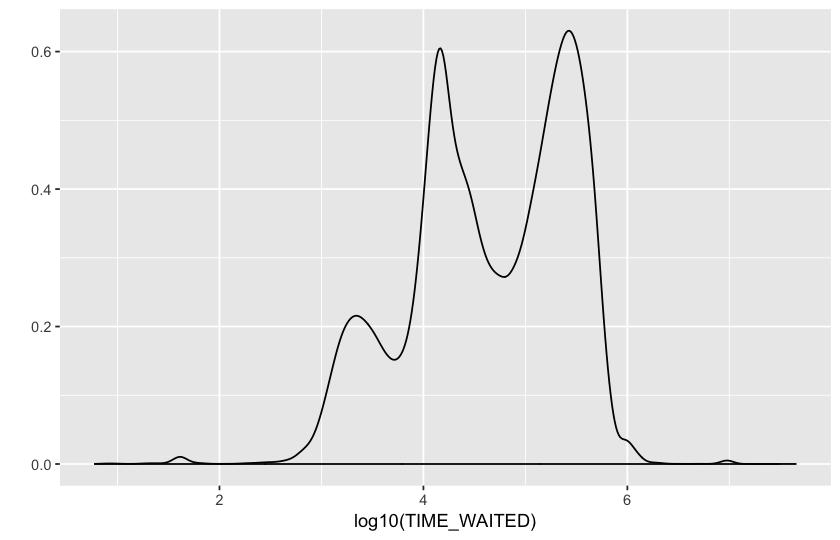

In [18]:
# use qplot and geom = c("density")
qplot(data = Events, x = log10(TIME_WAITED), geom = c("density"))

This plot exhibits three distinct peaks in the sample densities. The two highest of these and most of the probability are beteen 10 milliseconds and 1 second. However, these are *sampled* events, and the sampler is biased to longer events. So our collection of events is not independent of latency and thus does not represent the distribution of latencies fairly.

What if we are interested in the actual distribution of event latencies? Can we somehow undo the sampler bias and estimate what might actually be occurring from the sampled events?

## Estimating event occurrences
It turns out that we can use the samples to estimate the volume of actual event occurrences, and from that compute weighted probability density representations of the actual latency distributions. This is done using a technique developed and proven by Uri Shaft that makes intuitive sense. For an event sampled by a 1000000 microsecond (1 sec) sampling interval, divide 1000000 by `TIME_WAITED` if `TIME_WAITED < 1000000` and otherwise set it to 1. So if we sample a 500 millisecond event, it *counts* for 2. Similarly, a 10 millisecond event counts for 100. So the count estimate is the inverse of the probability of being sampled:
-       count: `<sampling interval> / TIME_WAITED`
- probability: `TIME_WAITED / <sampling interval>` 

The ash data frames in `ashdat` compute the estimated count for each sampled event as follows:
 
 `ashDF$EST_COUNT <- as.integer(dplyr::if_else(ashDF$TIME_WAITED >0 & ashDF$TIME_WAITED <1000000,
                                 round(1000000/ashDF$TIME_WAITED),1))`

I note a bug in the code above that samples with `TIME_WAITED = 0` (ON CPU samples and any non-terminal samples for very long waits) will get `EST_COUNT = 1`. However this does not affect our analysis as the `Events` data frame is filtered for `TIME_WAITED > 0`

We use the `weight` aesthetic in `geom_density( )` to assign each sample a weight proportional to the estimated count. 

For density plots the weights must sum to 1, so each sample is weighted by its proportion of the total estimated count: `weight = EST_COUNT / sum( EST_COUNT)`

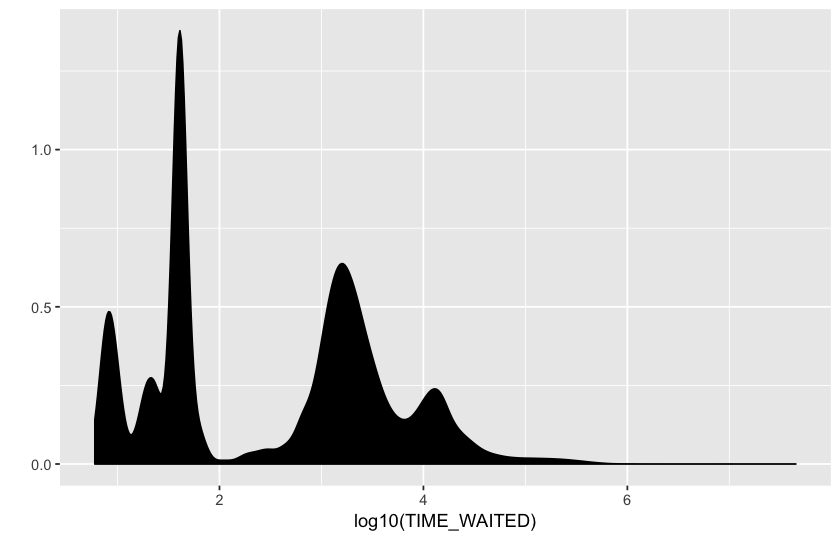

In [19]:
qplot(data = Events, x = log10(TIME_WAITED), geom = c("density")
     ,weight = EST_COUNT / sum( EST_COUNT ) , fill = I("black"))

The weighted density plot is vastly different from the sampled density. Most of the density is for latencies < 10 milliseconds, and a significant amount is less than 100 (= 10\*\*2) microseconds. We can see the effect of having sampled some very low-latency events, they get correspondingly high estimated counts. 

If we want to reason about how likely events are by latency, fitting unweighted samples is a serious misrepresentation. An interesting recent development in this area in a future notebook.

We plot the two together, coloring the sampled event count density in blue and tbe estimated event count density in red. This is done by adding separate `geom_density()` layers for each.

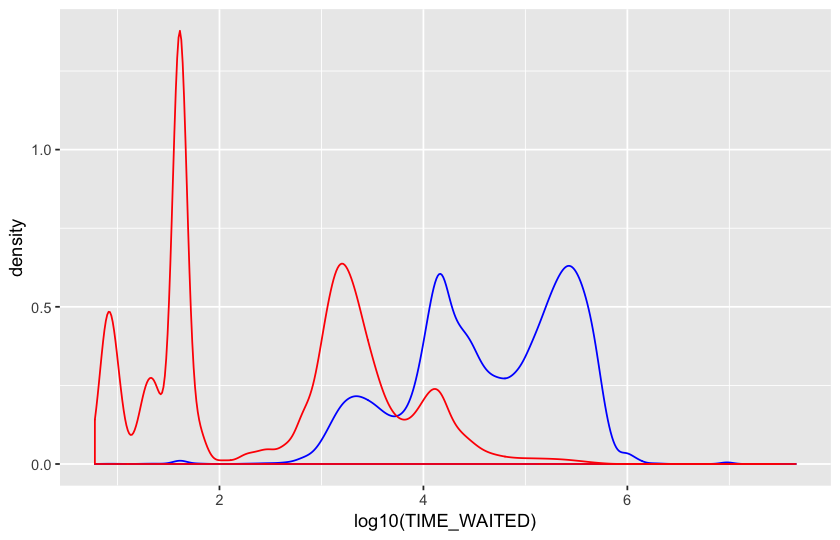

In [20]:
ggplot(data=Events, aes(x=log10(TIME_WAITED))) +
      geom_density(aes(color=I("blue"))) +
      geom_density(aes(color=I("red"), weight=EST_COUNT/sum(EST_COUNT)))

## Making semantic distinctions visual
One issue with the dual-density plot above is that the density fitted to the samples (in blue) and the density fitted to the EST_COUNT weighted samples really have different meanings, so displaying them both as smooth line charts, albeit of different colors, is visually misleading or at least not distinct enough.

So I thought to address this by filling in the sample density using alpha = 0.5, semi-transparent. Also, I reversed the colors to represent the weighted density in blue and the sample density in red:

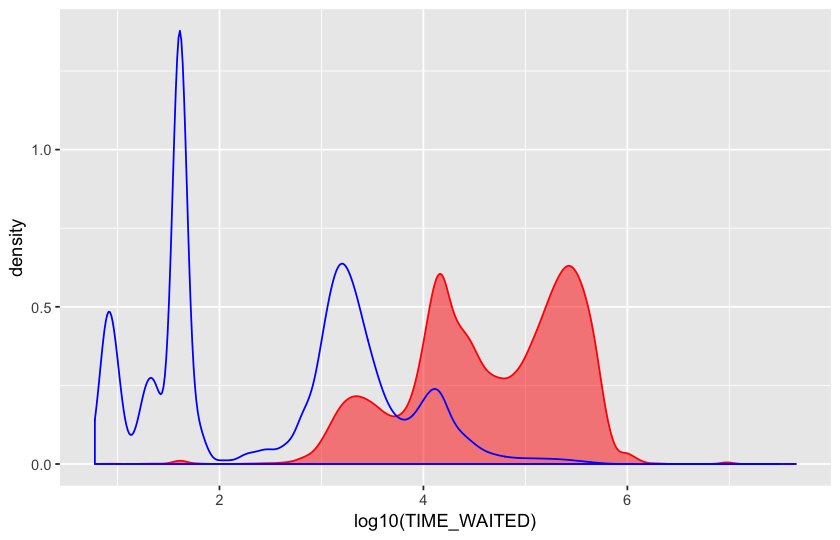

In [21]:
ggplot(data=Events, aes(x=log10(TIME_WAITED))) +
      geom_density(aes(color=I("red"), fill=I("red")), alpha=0.5) +
      geom_density(aes(color=I("blue"), weight=EST_COUNT/sum(EST_COUNT)))

I think this works quite well as a visualization. The sample and weighted densities are both clearly visible throughout the range, and they are visually distinct enough to encourage cognizance of the difference in meaning.

There is a lot more to muse about and investigate about measuring and estimating the density of event latencies, but that will have to be a future notebook as I don't want to extend this one any more now.

## Violin plots: geom_violin( )
Another visualization of the density is called the "violin" plot. Basically it's the density plot folded over th x-axis and then flipped up vertically. The symmetry seems to enhance the undertandability. First let's plot the sampled latencies.

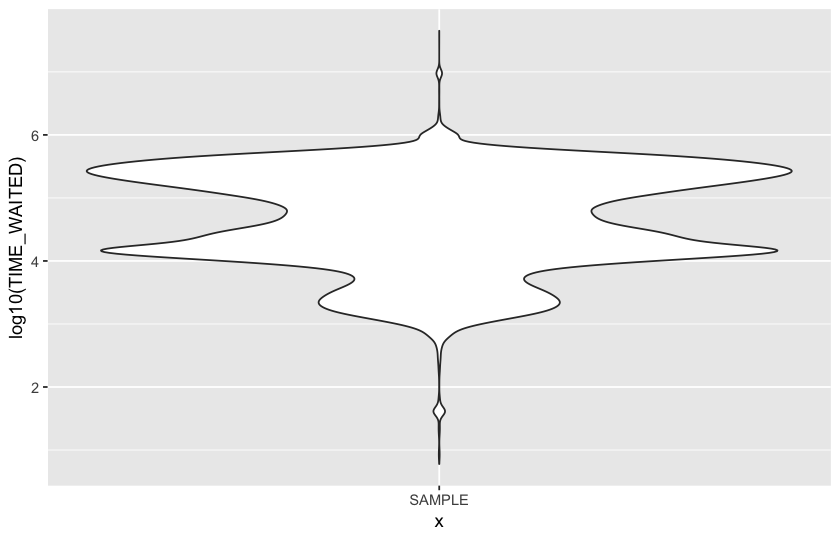

In [22]:
p <- ggplot(data=Events, aes(y=log10(TIME_WAITED)))

p +  geom_violin(aes(x="SAMPLE"))

We can see the resemblance to the density plot earlier, the three peaks have become three "wings" sticking out to the side. The two little "blips" in the tails are interesting as well.

## Weighted density violins

`geom_violin( )` can be weighted with the estimated counts in the same way as `geom_density( )` to provide an adjusted picture of the inferred actual distribution of event latencies in the system.

Warning message in density.default(x, weights = w, bw = bw, adjust = adjust, kernel = kernel, :
“sum(weights) != 1  -- will not get true density”

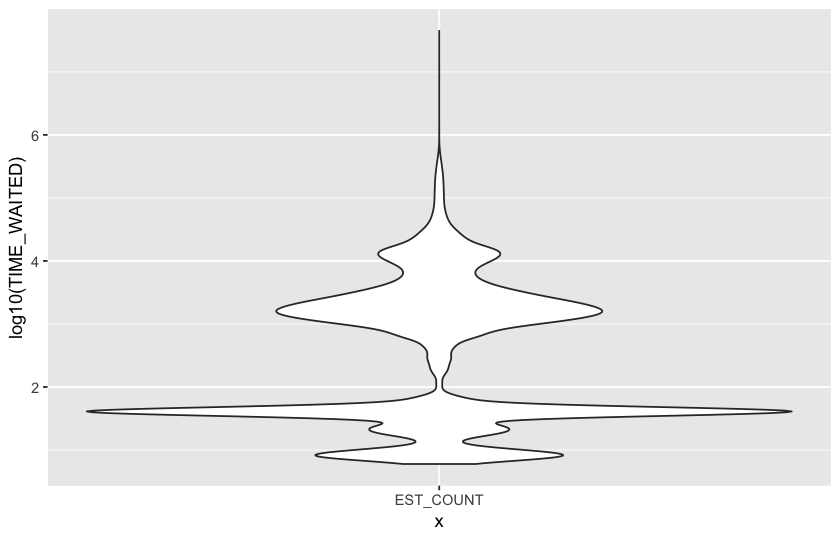

In [39]:
p +  geom_violin(aes(x = "EST_COUNT", weight = EST_COUNT ))

When we adjust the weight to the fraction of the total the warning message is dispatched, but the chart is identical. Seems like it should have worked without the addition, the density plots did (didn't they?)

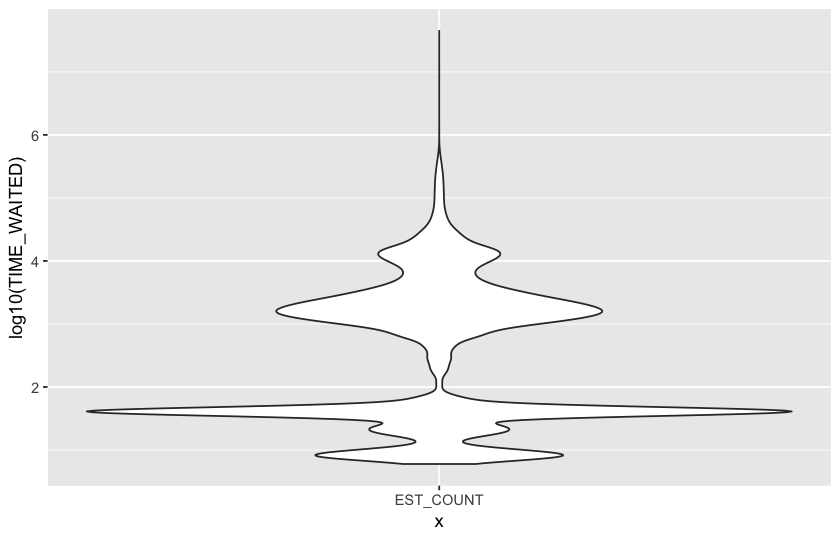

In [37]:
p +  geom_violin(aes(x = "EST_COUNT", weight=EST_COUNT / sum(EST_COUNT)))

So here we see again how the estimated latency distribution is much expanded in the lower latencies below 2 (or 100 microseconds.)

## Comparing sampled and estimated densities
Let's do a side-by-side comparison of sample count to estimated count densities using violin plots.

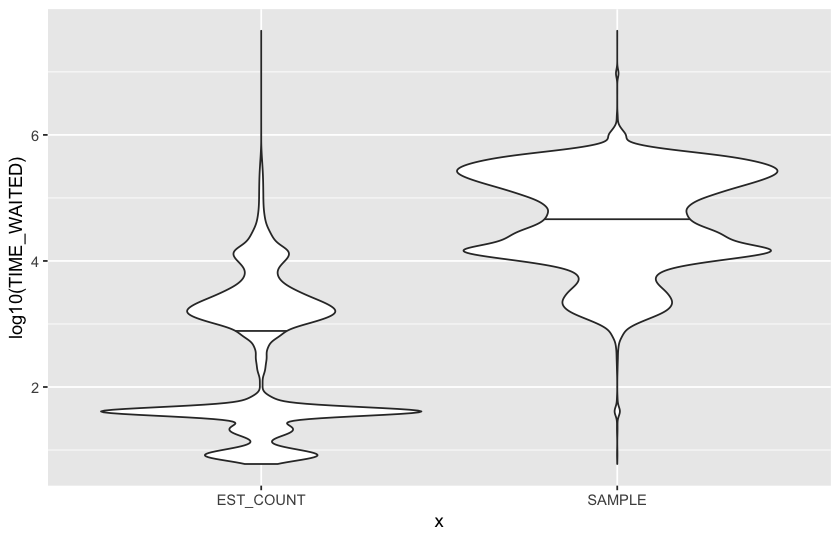

In [24]:
p +  geom_violin(aes(x = "SAMPLE"), draw_quantiles = (.5)) +
     geom_violin(aes(x = "EST_COUNT", weight = EST_COUNT/sum(EST_COUNT) ), draw_quantiles = (.5))

XXXXX Plotting both violins on same x value using red color fill with `alpha = 0.5` for sampled and a blue line for estimated occurrence densities, as done earlier with simple density plot. I think the side-by-side plots above are much better for comparison.

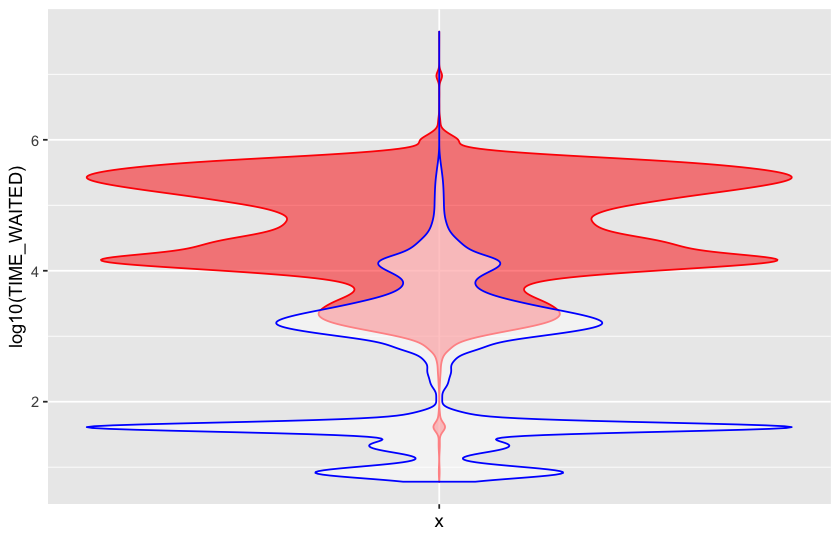

In [25]:
ggplot(data=Events, aes(x="1", y=log10(TIME_WAITED))) +
  geom_violin(aes(color=I("red"), fill=I("red")), alpha=.5) +
  geom_violin(aes(x="1", weight=EST_COUNT/sum(EST_COUNT), 
                  color=I("blue")),alpha=.5) +
  scale_x_discrete(labels=NULL)

## Comparing instances
Specifying `x = INSTANCE_NUMBER` aesthetic produces a separate violin for each instance. Here the plot shape definitely helps with making comparison, the mind can recognize similarities and differences better. This makes the violin plot a good solution for comparing things like benchmark runs, where distributions of many sets of performance measurements can be compared rapidly using the parallelism inherent in visual image cognition. This is consistent with the principle of "small multiples" discussed by Edward Tufte.

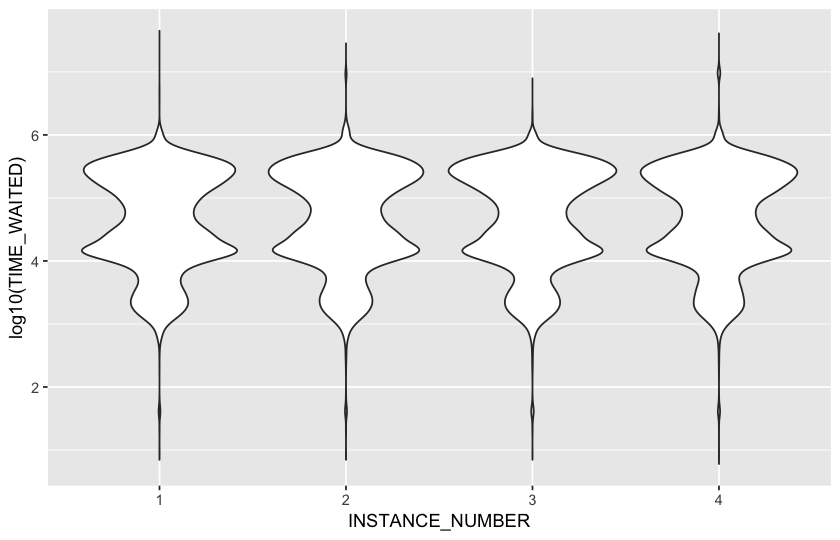

In [26]:
ggplot(data=Events, aes(x=INSTANCE_NUMBER, y=log10(TIME_WAITED))) +
  geom_violin()

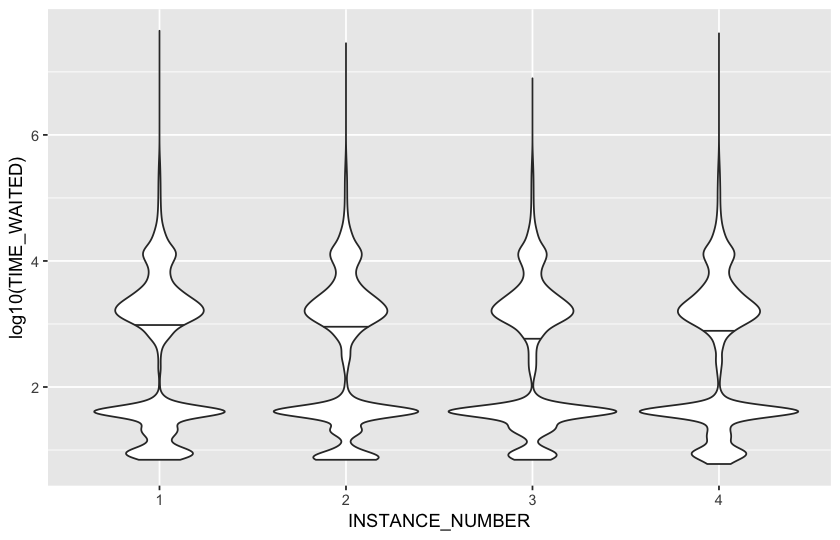

In [27]:
ggplot( data = Events %>% group_by(INSTANCE_NUMBER) %>% mutate(INST_TOT = sum(EST_COUNT))
      , aes( x = INSTANCE_NUMBER, y = log10(TIME_WAITED) ) ) +
  geom_violin( aes( weight = EST_COUNT / INST_TOT ), draw_quantiles = (.5) )

There are some subtle differences in these violin plots, especially in the lower latency region. Not sure what to make of it, probably not much. The fact that we can see such subtle differences does illustrate one of the strengths of the violin plot: doing acute visual comparisons of multiple, even many, densities against each other in same plot. Using violin plots for comparison seems well suited when looking for a standout or outlier among many expected identical densities. 

## Small multiples and comparisons
I wanted to investigate the "small multiples" idea a bit more so did some new experiments in this notebook not in the original R script. I had used violin plot visualization very successfully in benchmarking igest rates onto a big data platform. In this case I was looking for plot similarity within runs of a given configuration (indicating repeatable tests) and *similar differences* across configurations as concurrency increases past bottleneck level. The violin plots were really useful.

Here I started with separate violin plots for each wait class and tried to present them in a way that facilitates comparisons. The difference from benchmarking case is that there is no expectation that the violins will look similar, we are not measuring a highly controlled experiment with expectations for similarity or consistency.

An initial go turned out kind of OK. Here the x-axis is `WAITCLASS` and I thought using `scales = "free_x"` would line them all up vertically but they came out plotted in diagonal fashion which looks pretty cool but isn't all that great for comparing the plots against each other. For one thing, they are too squished vertically. Also there is too much unused space in the plot. It's OK to do small multiples, but they should be no smaller than necessary and not leave visual space unused.

## Class totals of EST_COUNT
This is something I finally figured out (kind of) which is warnings from density and violin plots that weights did not add up to 1. When using `weight` in `geom_violin` but separating the data on some other dimension, in this case `WAITCLASS` you want to weigh each wait class by it's fraction of the class total, e.g.:
`weight = EST_COUNT / CLASS_TOT`.

So we create a new data frame d from Events with the totals of `EST_COUNT` per waitclass in a variable `CLASS_TOT`:

In [28]:
d <- Events %>% mutate(TOT_TOT = sum(EST_COUNT)) %>% group_by(WAITCLASS) %>% mutate(CLASS_TOT = sum(EST_COUNT))
#str(d)

An initial go turned out odd but kind of OK. Here the x-axis is `WAITCLASS` and I thought using `scales = "free_x"` would line them all up vertically but they came out plotted in diagonal fashion which looks pretty cool but isn't all that great for comparing the plots against each other. For one thing, they are too squished vertically. Also there is too much unused space in the plot. It's OK to do small multiples, but they should be no smaller than necessary and not leave visual space unused.

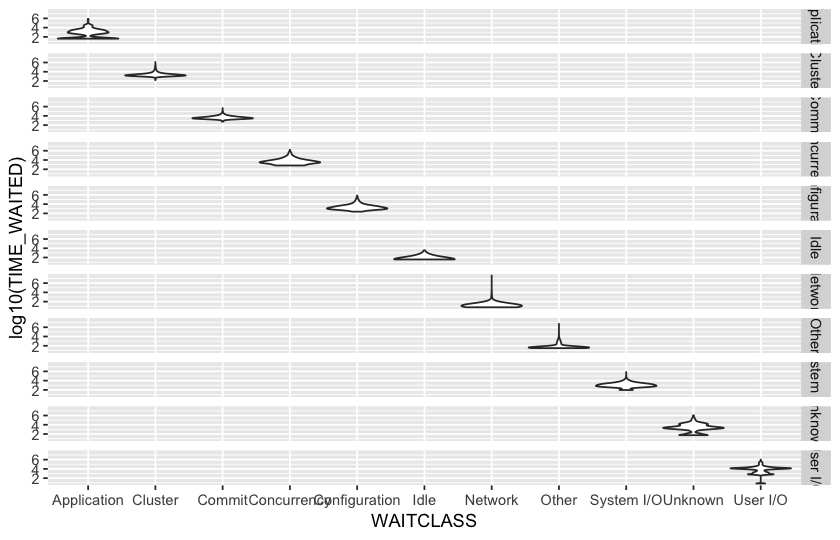

In [29]:
ggplot( data = d
      , aes( x = WAITCLASS, y = log10(TIME_WAITED) ) ) +
  geom_violin( aes( weight = EST_COUNT / CLASS_TOT ) ) +
  facet_grid(WAITCLASS ~., scales = "free_x")

What if we line them all up vertically using a constant x-value? Since the plot is faceted by `WAITCLASS` that will provide the distinct plots 

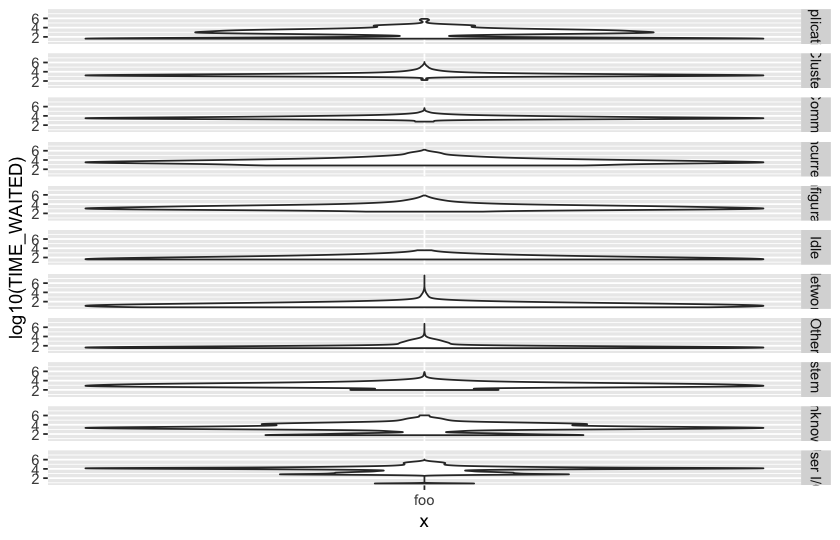

In [30]:
ggplot( data = d
      , aes( x = "foo", y = log10(TIME_WAITED) ) ) +
  geom_violin( aes( weight = EST_COUNT / CLASS_TOT) ) +
  facet_grid(WAITCLASS ~., scales = "free_x")

Yikes, guess not! That is about as inscrutable as a visualization could get.

There is a `scale` parameter to `geom_violin` that I could not understand the purpose. I decided to see if the plots looked any different under the 3 values ("area", "count", "width") by plotting them next to each other for each wait class.

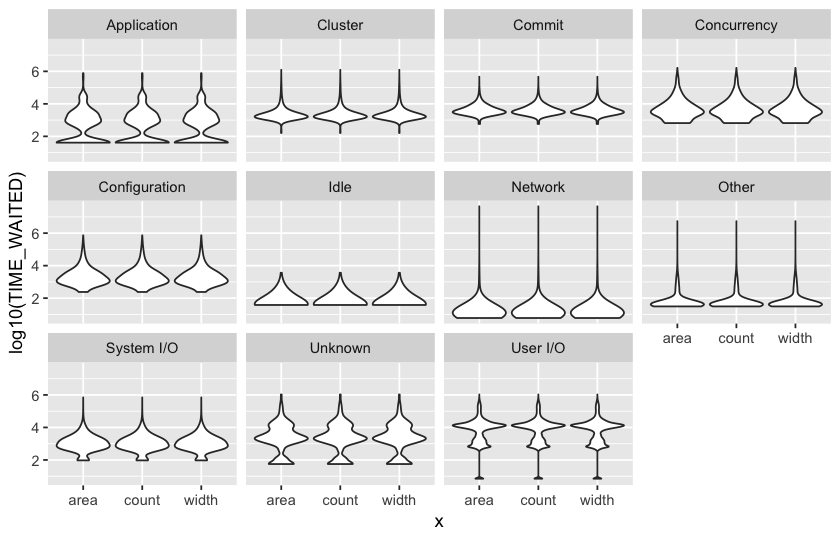

In [31]:
ggplot( data = d
      , aes( y = log10(TIME_WAITED) ) ) +
  geom_violin( aes( x = "area", weight = EST_COUNT/CLASS_TOT), scale = "area")  +
  geom_violin( aes( x = "count", weight = EST_COUNT/CLASS_TOT), scale = "count")  +
  geom_violin( aes( x = "width", weight = EST_COUNT/CLASS_TOT), scale = "width")  +
  facet_wrap(WAITCLASS ~.)

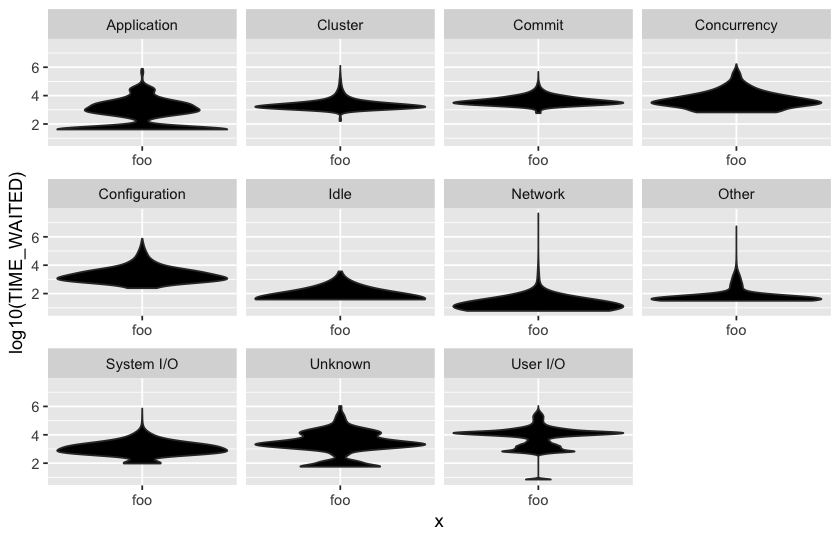

In [32]:
ggplot( data = d
      , aes( x = "foo", y = log10(TIME_WAITED) ) ) +
  geom_violin( aes( weight = EST_COUNT / CLASS_TOT , fill = I("black")) ) +
  facet_wrap(~WAITCLASS, scales = "free_x")

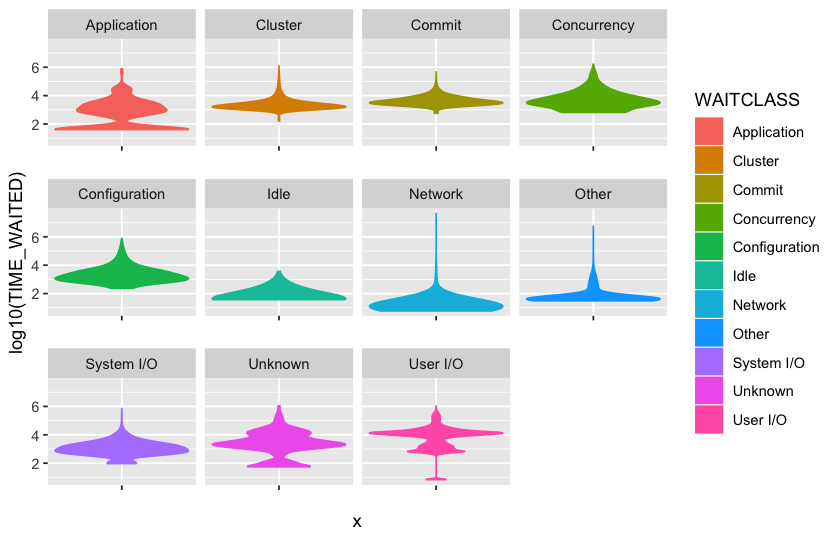

In [33]:
ggplot( data = Events %>% group_by(WAITCLASS) %>% mutate(CLASS_TOT = sum(EST_COUNT) )
      , aes( x = " ", y = log10(TIME_WAITED) ) ) +
  geom_violin( aes( weight = EST_COUNT / CLASS_TOT, color = WAITCLASS, fill = WAITCLASS ) ) +
  facet_wrap(~WAITCLASS, scales = "free_x")

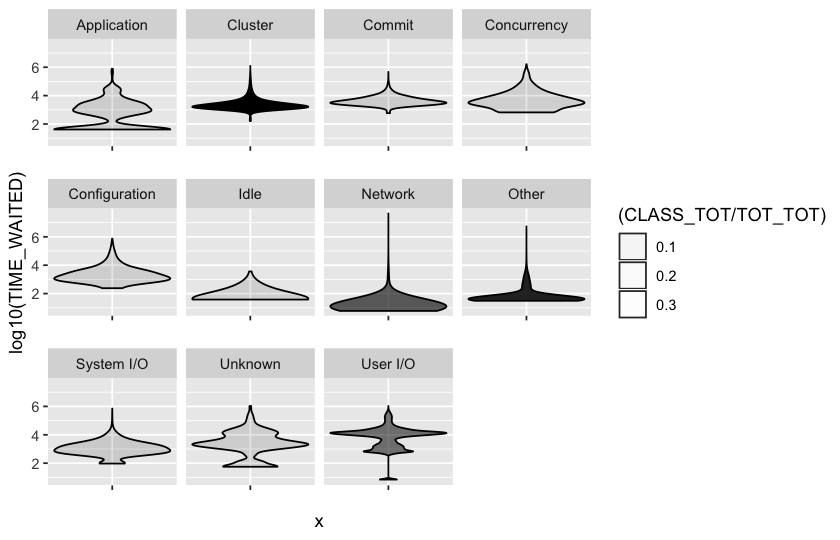

In [34]:
ggplot( data = d
      , aes( x = " ", y = log10(TIME_WAITED) ) ) +
  geom_violin( aes( weight = EST_COUNT / CLASS_TOT, color = I("black"), fill = I("black")
                  , alpha = (CLASS_TOT / TOT_TOT))) +
                 #  , alpha = ..scaled..)) +
  facet_wrap(~WAITCLASS, scales = "free_x")

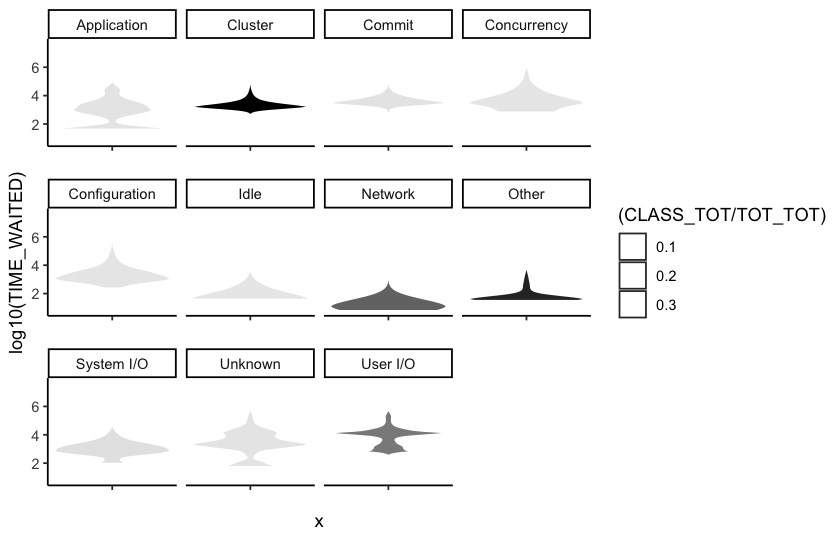

In [35]:
ggplot( data = d
      , aes( x = " ", y = log10(TIME_WAITED) ) ) +
  geom_violin( aes( weight = EST_COUNT / CLASS_TOT
                  , color = I("white") #alpha("black",0.1)
                  , fill = I("black"), alpha = (CLASS_TOT / TOT_TOT))) +
                 #  , alpha = ..scaled..)) +
  facet_wrap(~WAITCLASS, scales = "free_x") +
  theme_classic()

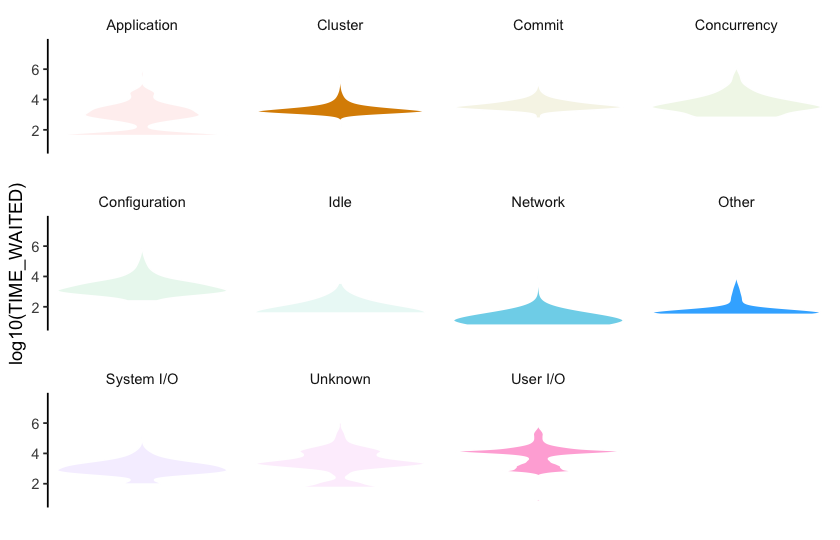

In [36]:
ggplot( data = d
      , aes( x = " ", y = log10(TIME_WAITED) ) ) +
  geom_violin( aes( weight = EST_COUNT / CLASS_TOT
                  , color = I("white") #alpha("black",0.1)
                  , fill = WAITCLASS, alpha = (CLASS_TOT / TOT_TOT))) +
                 #  , alpha = ..scaled..)) +
  facet_wrap(~WAITCLASS, scales = "free_x") +
  guides(fill=FALSE) + guides(alpha=FALSE) +   # remove fill and alpha guides
  theme_classic() +                            # theme classic has white background
  theme(axis.line.x = element_blank()) +      # remove x-axis
  theme(axis.ticks.x = element_blank()) +     # remove ticks
  theme(strip.background = element_blank()) +  # remove facet label boxes
  theme(axis.title.x = element_blank())

## Conclusions
This notebook was about looking at visual characterizations of the distribution of sampled event latencies from an ASH dump, starting with box-whisker plots and moving on to density plots and finally the violin density plots.

The ASH sampler is biased in the latency domain, so the samples in an ASH dump present a skewed view of the actual distribution of event latencies. We showed how to correct for this skew using the `EST_COUNT` variable to provide weighting factors for the density and violin plots.

The estimated event counts indicate the possibility of significant activity at quite low latencies, less than 100 microseconds. The Linux OS scheduler runs on a multi-millisecond timer (1) so on a CPU-saturated system low latency events could easily be extended 100x beyond normal, exaggerating their importance and perhaps misleading analysts. Identifying these events and their actual frequencies could improve risk management. 

## Learnings
-  estimating event counts from ASH samples
-  `geom_boxplot( )`
-  `geom_density( )`
-  `geom_violin( )`
-  `coord_flip( )`
-  `theme( )`
-  `alpha` 
-  `weight` adjustments

## References
